In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
data = pd.read_csv("data_cnn.csv")
data.shape

(5000, 7)

In [3]:
FROGS = np.loadtxt("FROG.csv", delimiter = ",")
FROGS = FROGS.reshape(5000, 128, 128, 1)

In [4]:
np.random.seed(3)
shuffler = np.random.permutation(len(FROGS))

X_orig = np.log(FROGS[shuffler])
X_orig = np.where(X_orig < -100, 0, X_orig)
X_orig = X_orig/np.max(np.abs(X_orig))
X_train = X_orig[:4700,:,:]
X_test = FROGS[4700:, :, :]

In [5]:
y_df = pd.DataFrame(columns=['T1','T2','A1','A2','F0','F1','Tau1'])
y_df["T1"] = data["T1"]/1000
y_df["T2"] = data["T2"]/1000
y_df["A1"] = data["A1"]/1.5
y_df["A2"] = data["A2"]/1.5
y_df["F0"] = data["F0"]/0.005
y_df["F1"] = data["F1"]/0.0005
#y_df["a2"] = data["a2"]/5e-6
#y_df["a3"] = data["a3"]/5e-9
y_df["Tau1"] = data["Tau1"]/5000
y_df.head(20)

,T1,T2,A1,A2,F0,F1,Tau1
0,0.30,0.98,0.500000,0.600000,0.4,-0.3,0.30
1,0.98,0.71,0.566667,0.933333,-0.1,0.7,0.96
2,0.73,0.97,0.500000,0.433333,-0.1,0.7,0.74
3,0.55,0.40,0.433333,0.866667,-0.5,-1.0,0.24
4,0.46,0.65,0.933333,0.933333,-0.3,-0.8,0.93
5,0.92,0.80,0.466667,0.866667,0.6,0.9,0.17
6,0.44,0.44,0.433333,0.966667,0.8,0.9,0.04
7,0.38,0.96,0.800000,0.833333,0.6,-0.6,0.02
8,0.81,0.86,0.633333,0.400000,-0.8,0.1,0.77
9,0.52,0.34,0.900000,0.966667,0.3,0.9,0.71


In [6]:
Y = y_df.to_numpy()
Y_train = Y[:4700,:]
Y_test = Y[4700:,:]

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

model = Sequential()
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(128,128,1)))
model.add(MaxPooling2D((2,2), padding="valid"))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D((2,2), padding="valid"))
model.add(Flatten())
model.add(Dense(7))

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 64)      640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 201607    
Total params: 220,711
Trainable params: 220,711
Non-trainable params: 0
________________________________________________

In [12]:
model.compile(optimizer="adam", loss="mae", metrics=["accuracy"])

In [ ]:
model.fit(X_train, Y_train, epochs=10, batch_size=128)


Epoch 1/10
4700/4700 [==============================] - 147s 31ms/step - loss: 0.3171 - accuracy: 0.2187
Epoch 2/10
4700/4700 [==============================] - 141s 30ms/step - loss: 0.2866 - accuracy: 0.2251
Epoch 3/10
4224/4700 [=========================>....] - ETA: 14s - loss: 0.2865 - accuracy: 0.2318

## Additional Functions for making trace plots

In [ ]:
import matplotlib.pylab as plt
from pylab import *
import sys

In [ ]:
e0 = np.loadtxt('837nm.dat')		#load the reference pulse, pump @836 nm
e0 = e0.T
e1 = np.sqrt(e0[1])
e1_ph = e0[2]
e = np.array(e1)*np.exp(-1j*(np.array(e1_ph)))		#reforming E-field

original_trace = np.loadtxt('trace/trace1.frg')		#load FROG trace from experiment

N = len(e0[0])		#timesteps
N_max = np.max(e0[0])
N_min = np.min(e0[0])

t = e0[0]-N_min
T0 = N_max-N_min	#total time duration
dt = T0/(N-1)
df = 1.0/T0		#frequency steps
TD = N			#time delay for FROG-trace generation
freq = np.arange(0,1/dt+df,df)*1000

In [ ]:
## for generation of Gaussian pulses
def gaussian_pulse(T,f,A,phase,tau):
	w0 = f*2*np.pi		#central angular frequency of pulse
	temp = -1j*w0*(t-tau) + 1j*phase
	E = A*np.sqrt(np.exp(-4.0*np.log(2.0)/np.log(np.e)*((t-tau)/T)**2))*np.exp(-temp)
	return E

In [ ]:
## calculate cross correlation of two pulses
def xcorr(e0,e,td):		#shift one pulse by time delay of 'td'
	E_delay = e*1.0
	if td<=0:
		E_delay[0:N+td] = e0[-td:]
		E_delay[N+td:] = [0]*(-td)
	else:
		E_delay[0:td] = [0]*(td)
		E_delay[td:] = e0[0:N-td]	
	return  e*E_delay

In [ ]:
## calculate the differert of trace A and trace B
def array_diff(A,B):
	A = A/np.max(A)
	B = B/np.max(B)
	return np.sum(np.square(A-B))/np.sum(np.square(A))

In [ ]:
def FROG_generator(e,E,TD):	
	FROG = np.zeros((TD,N),dtype=float)
	for td in range(-TD//2,TD//2):
		E_corre = xcorr(e,E,td)
		temp0 = np.fft.fftshift(np.fft.fft(E_corre))
		FROG[(td+TD//2)-1] = abs(temp0)**2	
	return FROG.T

In [ ]:
## calculate FROG traces with different time delays
def FROGs(T1,T2,A1,A2,f0,f1,tau1):
    tau2 = tau1-700
    phase1 = a2*(t-tau1)**2+a3*(t-tau1)**3
    phase2 = a2*(t-tau2)**2+a3*(t-tau2)**3 
    E1 = gaussian_pulse(T1,f0,A1,phase1,tau1)
    E2 = gaussian_pulse(T2,f1,A2,phase2,tau2)
    E = E1+E2
    FROG = FROG_generator(e,E,TD)
    delta = array_diff(FROG, original_trace)	
    return FROG, delta

In [ ]:
## plot out FROG trace
def FROG_trace_plot(FROG):
	fig,ax = plt.subplots()
	plt.imshow(FROG)
	plt.title("FROG trace")
	plt.grid(True)
	plt.show()

In [ ]:
a2 = 2.50*10**-6
a3 = 3.0*10**-9

## Prediction Function for model

In [ ]:
def plot_trace(params):
    print(params)
    (FROG,_) = FROGs(params[0]*1000, params[1]*1000 , params[2]*1.5, params[3]*1.5, params[4]*0.005 , params[5]*0.0005, params[6]*5000)
    FROG_trace_plot(FROG)
    return FROG

In [ ]:
def predict_trace(trace):
    y_pred = model.predict(trace).reshape(7)
    print(y_pred)
    (FROG,_) = FROGs(y_pred[0]*1000, y_pred[1]*1000 , y_pred[2]*1.5, y_pred[3]*1.5, y_pred[4]*0.005 , y_pred[5]*0.0005, y_pred[6]*5000)
    FROG_trace_plot(FROG)
    return FROG

[ 6.5195184  1.648932   0.5529225  5.5435095  1.2567935  4.7117543
 -2.122592 ]


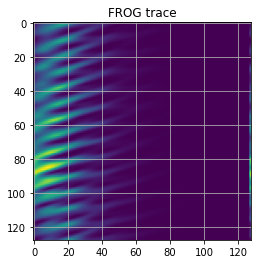

In [87]:
f1 = predict_trace(X_test[0].reshape(1,128,128,1))

[ 0.77        0.97        0.6         0.86666667 -0.7        -0.6
  0.08      ]


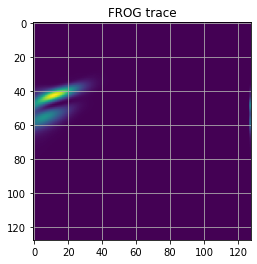

In [88]:
f2 = plot_trace(Y_test[0])

In [89]:
array_diff(f1, f2)

0.9287960210703359

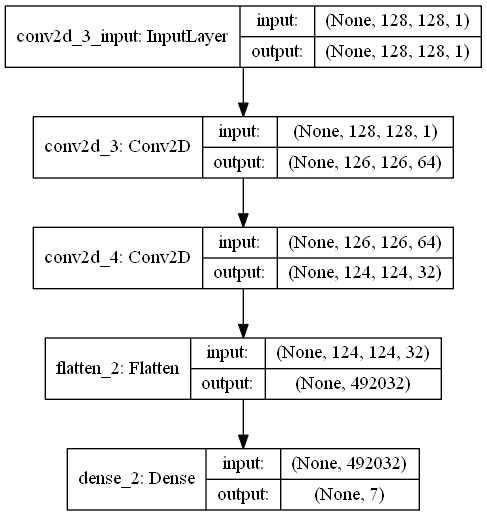

In [90]:
from keras.utils import plot_model

plot_model(model, to_file="cnn_model_plot.png", show_shapes=True, show_layer_names=True)